In [56]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Imports

In [57]:
from synbio_morpher.utils.data.data_format_tools.common import load_json_as_dict
from synbio_morpher.utils.circuit.agnostic_circuits.circuit_manager import CircuitModeller
from synbio_morpher.utils.common.setup import construct_circuit_from_cfg, prepare_config, expand_config
from synbio_morpher.utils.data.data_format_tools.common import load_json_as_dict
from synbio_morpher.srv.io.manage.script_manager import script_preamble
from synbio_morpher.utils.results.analytics.naming import get_true_interaction_cols
from synbio_morpher.utils.circuit.agnostic_circuits.circuit_manager import CircuitModeller
from synbio_morpher.utils.common.setup import construct_circuit_from_cfg, prepare_config
from synbio_morpher.utils.data.data_format_tools.common import load_json_as_dict
from synbio_morpher.utils.data.data_format_tools.manipulate_fasta import load_seq_from_FASTA
from synbio_morpher.utils.evolution.evolver import Evolver
from synbio_morpher.utils.evolution.mutation import apply_mutation_to_sequence, get_mutation_type_mapping, reverse_mut_mapping
from synbio_morpher.utils.misc.type_handling import flatten_listlike
from synbio_morpher.utils.results.writer import DataWriter
from synbio_morpher.srv.io.loaders.circuit_loader import load_circuit

import os
import sys
import numpy as np
import jax.numpy as jnp
import jax

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

jax.config.update('jax_platform_name', 'gpu')


# if __package__ is None:

module_path = os.path.abspath(os.path.join('..'))
sys.path.append(module_path)

__package__ = os.path.basename(module_path)

rng = jax.random.PRNGKey(0)

jax.devices()



[cuda(id=0)]

In [58]:
fn = '../data/processed/ensemble_mutation_effect_analysis/2023_07_17_105328/tabulated_mutation_info.csv'
fn_test_data = '../data/raw/ensemble_mutation_effect_analysis/2023_10_03_204819/tabulated_mutation_info.csv'
data = pd.read_csv(fn, index_col=0)
# data = pd.concat([pd.read_csv(fn), pd.read_csv(fn_test_data)])
# tdata = pd.read_csv(fn_test_data)
len(data)

1629000

In [59]:
# try:
#     data = data.drop(columns=['Unnamed: 0'])
# except:
#     pass


# Robustness metric

Testing a robustness metric with sensitivity and precision.

In [60]:
def calc_robustness(s, p, sp_factor=1, s_weight=0):
    """ Log product of s and p """
    s_lin = 1/p
    s = s * s_weight 
    return s * (p * (s - s_lin)) # * sp_factor + s_weight)


def mag(vec, **kwargs):
    return jnp.linalg.norm(vec, **kwargs)


def vec_distance(s, p, d):
    """ First row of each direction vector are the x's, second row are the y's """
    P = jnp.array([s, p]).T
    # P = [s.T, p.T]
    sp_rep = np.repeat(d[:, 0][:, None], repeats=len(s), axis=-1).T[:, :, None]
    AP = jnp.concatenate([sp_rep, P[:, :, None]], axis=-1)
    area = mag(jnp.cross(AP, d[None, :, :], axis=-1), axis=-1)
    D = area / mag(d)
    return D
    

def log_distance(s, p):
    lin = np.array([np.logspace(6, -3, 2), np.logspace(-6, 3, 2)])
    return vec_distance(s, p, lin)

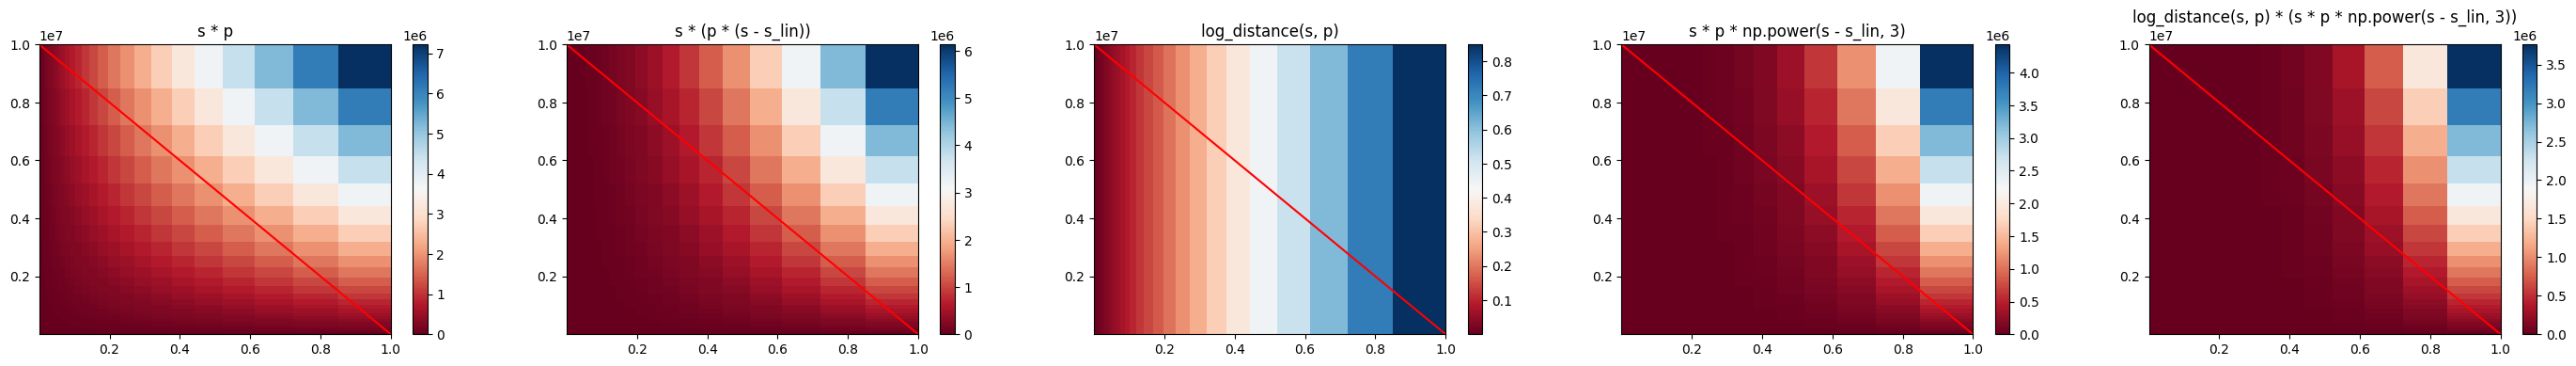

In [61]:
s, p = np.meshgrid(np.logspace(-7, 0, 100), np.logspace(0, 7, 100))

# z = jax.vmap(log_distance)(s=s, p=p) * calc_robustness(s=s, p=p, s_weight=10)
def plot_cmesh(z, ztext, iplot, ncol, nrow):
    z = z[:-1, :-1]
    z_min, z_max = np.abs(z).min(), np.abs(z).max()

    ax = plt.subplot(nrow, ncol, iplot)

    c = ax.pcolormesh(s, p, z, cmap='RdBu', vmin=z_min, vmax=z_max)
    ax.set_title('pcolormesh')
    ax.axis([s.min(), s.max(), p.min(), p.max()])
    fig.colorbar(c, ax=ax)
    
    plt.title(ztext)

    plt.plot(np.logspace(-7, 0, 2), np.logspace(7, 0, 2), 'r')
    # plt.xscale('log')
    # plt.yscale('log')

s_lin = 1/p
z1 = s * p
z2 = s * (p * (s - s_lin))
z3 = jax.vmap(log_distance)(s, p)
z4 = s * p * np.power(s - s_lin, 3)
z5 = jax.vmap(log_distance)(s, p) * (s * p * np.power(s - s_lin, 3))
zs = [z1, z2, z3, z4, z5]
ztexts = ['s * p', 's * (p * (s - s_lin))', 'log_distance(s, p)', 's * p * np.power(s - s_lin, 3)', 'log_distance(s, p) * (s * p * np.power(s - s_lin, 3))']

ncol = len(zs)
nrow = 1
fig = plt.figure(figsize=(7*ncol, 4*nrow))

for i, (zi, zt) in enumerate(zip(zs, ztexts)):
    plot_cmesh(zi, zt, i+1, ncol, nrow)

# plt.show()

## Robustness function

In [62]:
def calc_robustness(s, p, s_skew: int = 5):
    # s, p = np.log10(s), np.log10(p)
    high_num = 1e10
    p = np.where(p > high_num, high_num, p)
    s_lin = 1/p
    return s * p * np.power(s - s_lin, s_skew)
    

In [63]:
# np.log10(np.power(data['sensitivity_wrt_species-6'], 2)) / (np.log10(np.sqrt(data['precision_wrt_species-6'])) / 100)
data['robustness'] = calc_robustness(data['sensitivity_wrt_species-6'].to_numpy(), data['precision_wrt_species-6'].to_numpy(), s_skew=8)

In [64]:
data['robustness'].apply(['min', 'max', 'mean', 'std'])

min     2.322914e-129
max      2.153379e+02
mean     2.229887e-01
std      3.397374e+00
Name: robustness, dtype: float64

### Plots

Text(0.5, 0.98, 'Overshoot threshold = 1e-05')

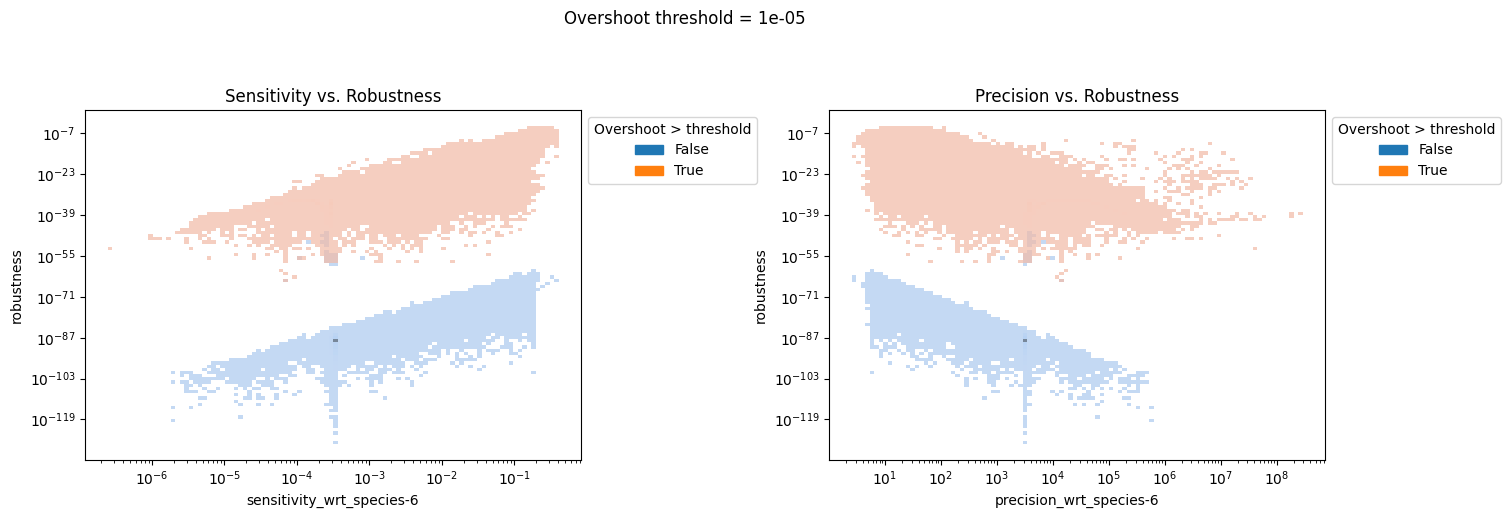

In [ ]:
p = 1e-5

fig = plt.figure(figsize=(8*2, 5*2))
fig.subplots_adjust(wspace=0.5)

ax = plt.subplot(2,2,1)
data['Overshoot > threshold'] = data['overshoot'] > p
ax = sns.histplot(data[data['sample_name'] != 'RNA_0'], y='robustness', x='sensitivity_wrt_species-6', hue='Overshoot > threshold', bins=100, element='step', log_scale=[True, True], alpha=0.7)
plt.title('Sensitivity vs. Robustness')
sns.move_legend(ax, 'upper left', bbox_to_anchor=(1, 1))
ax = plt.subplot(2,2,2)
sns.histplot(data[data['sample_name'] != 'RNA_0'], y='robustness', x='precision_wrt_species-6', hue='Overshoot > threshold', bins=100, element='step', log_scale=[True, True], alpha=0.7)
plt.title('Precision vs. Robustness')
sns.move_legend(ax, 'upper left', bbox_to_anchor=(1, 1))

plt.suptitle(f'Overshoot threshold = {p}')

<Axes: xlabel='robustness', ylabel='Count'>

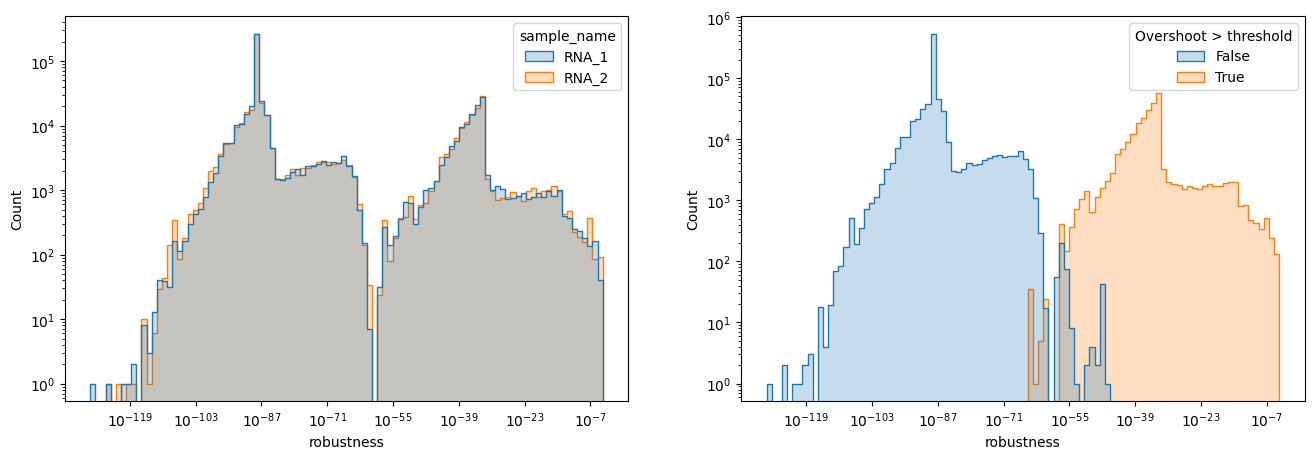

In [ ]:
fig = plt.figure(figsize=(8*2, 5))
ax = plt.subplot(1,2,1)
sns.histplot(data[data['sample_name'] != 'RNA_0'], x='robustness', bins=100, element='step', hue='sample_name', log_scale=[True, True])
ax = plt.subplot(1,2,2)
sns.histplot(data[data['sample_name'] != 'RNA_0'], x='robustness', bins=100, element='step', hue='Overshoot > threshold', log_scale=[True, True])


### S vs. P

Text(0.5, 1.0, 'Robustness metric: sensitivity vs. precision')

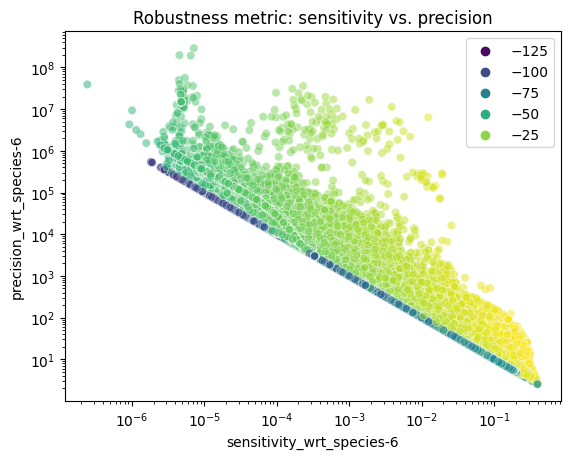

In [ ]:
sns.scatterplot(data=data[data['sample_name'] != 'RNA_0'], x='sensitivity_wrt_species-6', 
                y='precision_wrt_species-6', 
                hue=np.log10(data[data['sample_name'] != 'RNA_0']['robustness'].to_numpy()), palette='viridis', alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.title('Robustness metric: sensitivity vs. precision')

## Verify that the traces ranking high on robustness are actually robust-looking

In [92]:
run_intarna = True

config = {
    "system_type": "RNA",
    "include_prod_deg": False,
    "data": {s: '02_simple_mlp_species.ipynb' for s in list(data['sample_name'].unique())},
    "experiment": {
        "purpose": "tests",
        "debug_mode": False,
        "no_visualisations": True,
        "no_numerical": True
    },
    "interaction_simulator": {
        "name": "IntaRNA",
        "postprocess": True,
        "simulator_kwargs": {
            "outcsvcols": "id1, id2, E, E_norm, bpList, hybridDPfull, seedPu1, seedPu2, seedStart1, seedStart2, seedEnd1, seedEnd2",
            "threads": 12,
            "n": 1,
            "raw_stdout": True
        }
    },
    "molecular_params_factor": 1,
    "molecular_params": {
        "avg_mRNA_per_cell": 100,
        "cell_doubling_time": 1200,
        "creation_rate": 2.35,
        "starting_copynumbers": 200,
        "degradation_rate": 0.01175,
        "association_binding_rate": 1000000
    },
    "signal": {
        "inputs": ["RNA_0"],
        "outputs": ["RNA_1"],
        "function_name": "step_function",
        "function_kwargs": {
            "impulse_center": 1, 
            "impulse_halfwidth": 5, 
            "target": 2
        }
    },
    "simulation": {
        "dt0": 0.1,
        "t0": 0,
        "t1": 100,
        "tmax": 2000,
        "max_time": 100,
        "time_interval": 100,
        "solver": "diffrax",
        "steady_state_solver": "diffrax",
        "use_zero_rates": True,
        "method": "Tsit5",
        "use_batch_mutations": True,
        "interaction_factor": 1,
        "batch_size": 20000,
        "max_circuits": 60000,
        "device": "gpu",
        "threshold_steady_states": 0.05, 
        "use_rate_scaling": True
    },
    "system_type": "RNA",
}
config['simulation_steady_state'] = config['simulation']


data_writer = None
config, data_writer = script_preamble(config, data_writer)
config = prepare_config(expand_config(config=config))

## Funcs

In [93]:
root_dir = '..'


def make_next_name(name: str, subname: str):
    return name + '_' + subname


def get_mutated_sequences(path, circ_row, mutation_type_mapping) -> dict:
    
    if not os.path.isfile(path):
        path = os.path.join(root_dir, path)
        assert os.path.isfile(path), f'Path {path} is not valid.'
    
    if circ_row['mutation_name'] == 'ref_circuit': 
        return path

    sequences = load_seq_from_FASTA(path, as_type = 'dict')
    mutated_species = circ_row['mutation_name'][:5]
    mutation_types = jax.tree_util.tree_map(lambda x: mutation_type_mapping[x], circ_row['mutation_type'])
    mutated_sequence = apply_mutation_to_sequence(
        sequences[mutated_species], circ_row['mutation_positions'], mutation_types)
    
    sequences[mutated_species] = mutated_sequence
    return sequences

    
def process_for_next_run(circuits: list, data_writer: DataWriter):
    
    for i, c in enumerate(circuits):
        circuits[i].name = make_next_name(c.name, c.subname)
        # sequences = {s.name: s.physical_data for s in c.model.species if s.physical_data}
        sequences = load_seq_from_FASTA(c.data.source, as_type='dict')
        circuits[i].data.source = write_mutated_circuit(
            name=circuits[i].name, subname='ref_circuit', sequences=sequences, data_writer=data_writer)
    return circuits
    
    
def write_mutated_circuit(
    name: str, subname: str, sequences, data_writer: DataWriter):
    
    data_writer.subdivide_writing(name)
    if subname != 'ref_circuit':
        data_writer.subdivide_writing(subname, safe_dir_change=False)
    
    new_path = data_writer.output(
        out_name=name,
        out_type='fasta', return_path=True,
        data=sequences, byseq=True
    )
    
    data_writer.unsubdivide()
    return new_path


def make_symmetrical_matrix_from_sequence(arr, side_length: int):
    """ For a flat 1D array, make a symmetrical 2D matrix filling
    in the upper triangle with the 1D array. """
    if len(arr) < (side_length ** 2):
        p = flatten_listlike([[str(tuple(sorted([i, j]))) for i in range(side_length)] for j in range(side_length)])
        # d = {pi: i for i, pi in enumerate(set(p))}
        d = np.concatenate([np.where(np.array(sorted(set(p))) == pi)[0] for pi in p]).astype(int)
        arr = arr[d]
    i = np.triu(
        np.arange(side_length * side_length).reshape(side_length, side_length))
    # idxs = np.interp(ii, np.unique(ii), np.arange(len(arr))).astype(int)
    ii = i + i.T - np.diag(i.diagonal())
    return arr[ii.flatten()].reshape(side_length, side_length)


def make_starting_circuits(starting_circuits: pd.DataFrame, config: dict, data_writer):
    # d = {v: v for v in jax.tree_util.tree_flatten(get_mutation_type_mapping('RNA'))[0]}
    # mutation_type_mapping_rev = jax.tree_util.tree_map(lambda x: reverse_mut_mapping(x), d)

    circuits = []
    for i, circ_row in starting_circuits.iterrows():
        curr_config = config
        # sequences = get_mutated_sequences(circ_row['path_to_template_circuit'], circ_row, mutation_type_mapping_rev)
        # path = write_mutated_circuit(
        #     name=circ_row['circuit_name'],
        #     subname=circ_row['mutation_name'],
        #     sequences=sequences,
        #     data_writer=data_writer)
        # curr_config['data_path'] = path
        # from synbio_morpher.utils.misc.numerical import make_symmetrical_matrix_from_sequence
        curr_config['interactions_loaded'] = {}
        for e in ['energies', 'binding_rates_dissociation', 'eqconstants']:
            es = get_true_interaction_cols(starting_circuits, e, remove_symmetrical=True, num_species=3)
            m = make_symmetrical_matrix_from_sequence(circ_row[es].to_numpy(), side_length=3)
            curr_config['interactions_loaded'].update({e: m})
        curr_config['interactions'] = None
        circuit = construct_circuit_from_cfg(prev_configs=None, config_file=curr_config) 
        circuit.name = make_next_name(circ_row['circuit_name'], circ_row['mutation_name'])
        circuits.append(circuit)
        
    return circuits


In [94]:
def simulate(circuits: list, modeller: CircuitModeller, config: dict) -> list:
    
    circuits = modeller.batch_circuits(
        circuits=circuits,
        write_to_subsystem=True,
        batch_size=config['simulation'].get('batch_size', 100),
        methods={
            "compute_interactions": {},
            "init_circuits": {'batch': True},
            "simulate_signal_batch": {'ref_circuit': None,
                                      'batch': config['simulation']['use_batch_mutations']},
            "write_results": {'no_visualisations': config['experiment']['no_visualisations'],
                              'no_numerical': config['experiment']['no_numerical']}
        }
    )
    
    return circuits

### Make circuits

In [109]:
n_circuits = 100
jax.devices()

modeller = CircuitModeller(data_writer, config)
starting_circ_rows = data[data['sample_name'] == 'RNA_0'].sort_values('robustness')
starting_circ_rows = starting_circ_rows.drop_duplicates(get_true_interaction_cols(data, 'energies', remove_symmetrical=True))
starting_circ_rows = starting_circ_rows.iloc[:n_circuits]
circuits = make_starting_circuits(starting_circ_rows, config, data_writer)


simulator.py:check_IntaRNA_path():122: Could not detect IntaRNA on system: CompletedProcess(args='which IntaRNA', returncode=1, stdout='', stderr='') WARNING


In [110]:
circuits_sim = simulate(circuits, modeller, config)

circuit_manager.py:batch_circuits():690: 	From 100 circuits, a total of 100 mutated circuits will be simulated. WARNING
circuit_manager.py:batch_circuits():697: 		Starting new round of viable circuits (0 - 100 / 100) WARNING
circuit_manager.py:batch_circuits():715: 		Making subcircuits 0 - 100 took 0.000404s WARNING
circuit_manager.py:batch_circuits():721: 	Batching 0 - 20000 circuits (out of 0 - 100 (total: 100)) (Circuits: 0 - 100 of 100) WARNING
circuit_manager.py:run_batch():753: 		Running 100 Subcircuits - toy_mRNA_circuit_1057_RNA_2_m10-7: compute_interactions WARNING
circuit_manager.py:run_batch():789: 		Method compute_interactions took 0.097922s WARNING
circuit_manager.py:run_batch():753: 		Running 100 Subcircuits - toy_mRNA_circuit_1057_RNA_2_m10-7: init_circuits WARNING


Steady states:  100  iterations.  100  left to steady out.  0:00:32.954371
Steady states:  200  iterations.  4  left to steady out.  0:01:05.743407
Steady states:  300  iterations.  3  left to steady out.  0:01:38.508051
Steady states:  400  iterations.  2  left to steady out.  0:02:11.503129


circuit_manager.py:run_batch():789: 		Method init_circuits took 164.457431s WARNING
circuit_manager.py:run_batch():753: 		Running 100 Subcircuits - toy_mRNA_circuit_1057_RNA_2_m10-7: simulate_signal_batch WARNING
circuit_manager.py:prepare_internal_funcs():607: Signal differs between circuits, but only first signal used for simulation. WARNING


Done:  0:02:44.255356


circuit_manager.py:simulate_signal_batch():454: 		Simulating signal took 34.956594s WARNING


Done:  0:00:34.939034


circuit_manager.py:simulate_signal_batch():512: 		Calculating analytics took 5.024686s WARNING
circuit_manager.py:run_batch():789: 		Method simulate_signal_batch took 40.189124s WARNING
circuit_manager.py:run_batch():753: 		Running 100 Subcircuits - toy_mRNA_circuit_1057_RNA_2_m10-7: write_results WARNING
circuit_manager.py:run_batch():789: 		Method write_results took 0.347714s WARNING
circuit_manager.py:batch_circuits():735: Single batch: 0:03:25.095599 
Projected time: 205.095599s 
Total time: 0:03:25.095612 WARNING


[[0.0 0.0 0.0]
 [0.0 -20.42 0.0]
 [0.0 0.0 -17.5]]


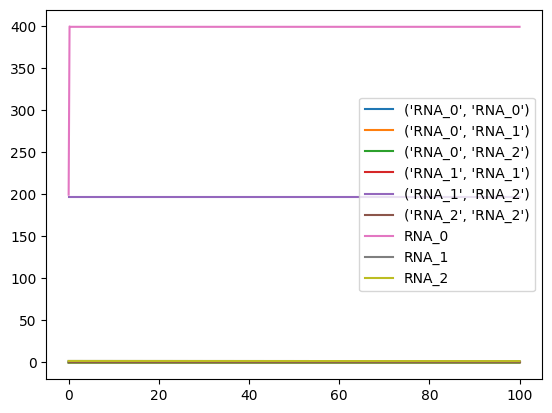

In [112]:
i = 21
plt.plot(circuits_sim[i].result_collector.results['signal'].vis_kwargs['t'], circuits_sim[0].result_collector.results['signal'].data.T)
plt.legend(circuits_sim[i].result_collector.results['signal'].vis_kwargs['legend'])

print(circuits_sim[i].interactions.energies)